## Mixup

In [16]:
from albumentations.pytorch import ToTensorV2
import albumentations as A
import torch
import numpy as np
import cv2

In [50]:
class AlbumentationsTransform:
    def __init__(self, is_train: bool = True):
        # 공통 변환 설정: 이미지 리사이즈, 정규화, 텐서 변환
        common_transforms = [
            A.Resize(224, 224),  # 이미지를 224x224 크기로 리사이즈
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # 정규화
            ToTensorV2()  # albumentations에서 제공하는 PyTorch 텐서 변환
        ]
        self.is_train = is_train

        if is_train:
            # 훈련용 변환: 랜덤 수평 뒤집기, 랜덤 회전, 랜덤 밝기 및 대비 조정 추가
            self.transform = A.Compose(
                [
                    A.HorizontalFlip(p=0.5),  # 50% 확률로 이미지를 수평 뒤집기
                    A.Rotate(limit=30),  # 최대 15도 회전
                    A.RandomBrightnessContrast(p=0.2),  # 밝기 및 대비 무작위 조정
                ] + common_transforms
            )
            self.basic = A.Compose(common_transforms)
        else:
            # 검증/테스트용 변환: 공통 변환만 적용
            self.basic = A.Compose(common_transforms)

    def __call__(self, image) -> torch.Tensor:
        # 이미지가 NumPy 배열인지 확인
        if not isinstance(image, np.ndarray):
            raise TypeError("Image should be a NumPy array (OpenCV format).")

        # 이미지에 변환 적용 및 결과 반환
        transformed = self.basic(image=image)  # 이미지에 설정된 변환을 적용

        if self.is_train:
            return transformed['image'], self.transform(image=image)['image']

        return transformed['image']  # 변환된 이미지의 텐서를 반환

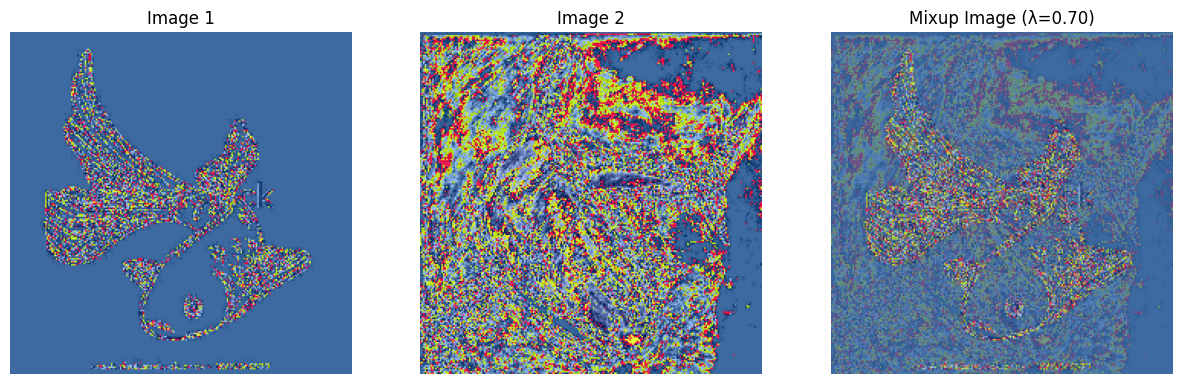

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def tensor_to_image(tensor):
    # 텐서의 크기와 값 범위를 조정 (채널을 마지막으로 이동, [0, 1] -> [0, 255])
    tensor = tensor.permute(1, 2, 0)  # [C, H, W] -> [H, W, C]
    tensor = tensor * 255
    tensor = tensor.byte()  # [0, 255] 범위로 변환
    return Image.fromarray(tensor.numpy())

# 두 이미지를 불러오는 함수
def load_image(path):
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # BGR 포맷을 RGB 포맷으로 변환합니다.
    transform = AlbumentationsTransform(is_train=False)
    image = transform(image)
    image = tensor_to_image(image)
    return image

# Mixup을 적용하는 함수
def mixup(image1, image2, alpha=0.5):
    # 이미지를 numpy 배열로 변환
    img1 = np.array(image1)
    img2 = np.array(image2)
    
    # 두 이미지의 크기가 동일한지 확인
    assert img1.shape == img2.shape, "Images must be the same size."
    
    # λ 값을 랜덤하게 [0, 1] 사이에서 생성 (여기서는 alpha를 고정값으로 설정)
    lam = np.random.beta(alpha, alpha)
    lam = 0.7
    
    # Mixup 이미지 생성
    mixed_img = lam * img1 + (1 - lam) * img2
    mixed_img = mixed_img.astype(np.uint8)  # 정수형 변환
    
    return mixed_img, lam

# 이미지를 시각화하는 함수
def plot_images(img1, img2, mixed_img, lam):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(img1)
    axes[0].set_title("Image 1")
    axes[0].axis("off")
    
    axes[1].imshow(img2)
    axes[1].set_title("Image 2")
    axes[1].axis("off")
    
    axes[2].imshow(mixed_img)
    axes[2].set_title(f"Mixup Image (λ={lam:.2f})")
    axes[2].axis("off")
    
    plt.show()

# 이미지 파일 경로 설정
image_path1 = "/data/ephemeral/data/train/n01443537/sketch_6.JPEG"
image_path2 = "/data/ephemeral/data/train/n01484850/sketch_21.JPEG"

# 이미지 불러오기
image1 = load_image(image_path1)
image2 = load_image(image_path2)

# Mixup 적용
mixed_image, lam = mixup(image1, image2)

# 시각화
plot_images(image1, image2, mixed_image, lam)


## CutMix

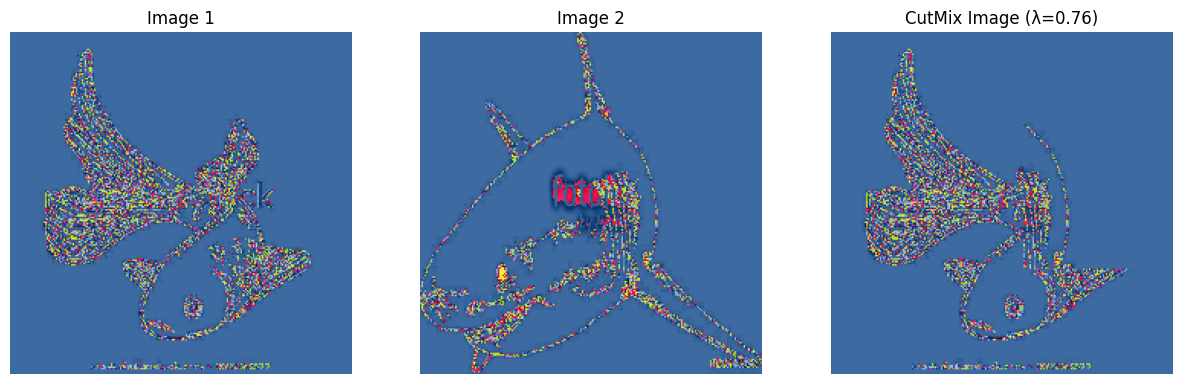

In [49]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Albumentations Transform 정의
class AlbumentationsTransform:
    def __init__(self, is_train=True):
        if is_train:
            self.transform = A.Compose([
                A.Resize(224, 224),
                A.HorizontalFlip(p=0.5),
                A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # 정규화,
                ToTensorV2()
            ])
        else:
            self.transform = A.Compose([
                A.Resize(224, 224),
                A.Normalize(),
                ToTensorV2()
            ])

    def __call__(self, image):
        return self.transform(image=image)['image']

# 텐서를 이미지로 변환하는 함수
def tensor_to_image(tensor):
    tensor = tensor.permute(1, 2, 0)  # [C, H, W] -> [H, W, C]
    tensor = tensor * 255
    tensor = tensor.byte()  # [0, 255] 범위로 변환
    return Image.fromarray(tensor.cpu().numpy())

# 이미지를 불러오는 함수
def load_image(path):
    image = Image.open(path).convert("RGB")  # 이미지를 PIL로 불러옴
    image = np.array(image)  # NumPy 배열로 변환
    transform = AlbumentationsTransform(is_train=False)
    image_tensor = transform(image=image)  # Albumentations 적용
    image = tensor_to_image(image_tensor)  # 텐서를 이미지로 변환
    return image_tensor

# CutMix를 적용하는 함수
def cutmix(image1, image2, alpha=1.0):
    # 두 이미지의 크기가 동일해야 함
    assert image1.shape == image2.shape, "Images must be the same size."
    
    # 이미지의 높이와 너비
    H, W = image1.shape[1], image1.shape[2]  # [C, H, W]
    
    # λ 값을 베타 분포로부터 샘플링 (랜덤으로 잘라낼 비율)
    lam = np.random.beta(alpha, alpha)
    lam = 0.7
    
    # 잘라낼 영역의 크기 계산 (Bounding box 좌표)
    cut_rat = np.sqrt(1. - lam)  # 자를 영역의 비율
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)
    
    # 자를 위치의 중앙점
    cx = np.random.randint(W)
    cy = np.random.randint(H)
    
    # Bounding box 좌표 계산
    x1 = np.clip(cx - cut_w // 2, 0, W)
    x2 = np.clip(cx + cut_w // 2, 0, W)
    y1 = np.clip(cy - cut_h // 2, 0, H)
    y2 = np.clip(cy + cut_h // 2, 0, H)
    
    # 이미지1에 이미지2의 일부를 붙임
    mixed_image = image1.clone()
    mixed_image[:, y1:y2, x1:x2] = image2[:, y1:y2, x1:x2]
    
    # 새로운 λ 값 (실제 잘린 영역의 비율)
    lam = 1 - ((x2 - x1) * (y2 - y1) / (W * H))
    
    return mixed_image, lam

# 이미지를 시각화하는 함수
def plot_images(img1, img2, mixed_img, lam):
    # 텐서를 이미지로 변환 (시각화를 위해)
    img1 = tensor_to_image(img1)
    img2 = tensor_to_image(img2)
    mixed_img = tensor_to_image(mixed_img)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(img1)
    axes[0].set_title("Image 1")
    axes[0].axis("off")
    
    axes[1].imshow(img2)
    axes[1].set_title("Image 2")
    axes[1].axis("off")
    
    axes[2].imshow(mixed_img)
    axes[2].set_title(f"CutMix Image (λ={lam:.2f})")
    axes[2].axis("off")
    
    plt.show()

# 이미지 파일 경로 설정
image_path1 = "/data/ephemeral/data/train/n01443537/sketch_6.JPEG"
image_path2 = "/data/ephemeral/data/train/n01484850/sketch_10.JPEG"

# 이미지 불러오기
image1 = load_image(image_path1)
image2 = load_image(image_path2)

# CutMix 적용
mixed_image, lam = cutmix(image1, image2)

# 시각화
plot_images(image1, image2, mixed_image, lam)


## CoarseDropout

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


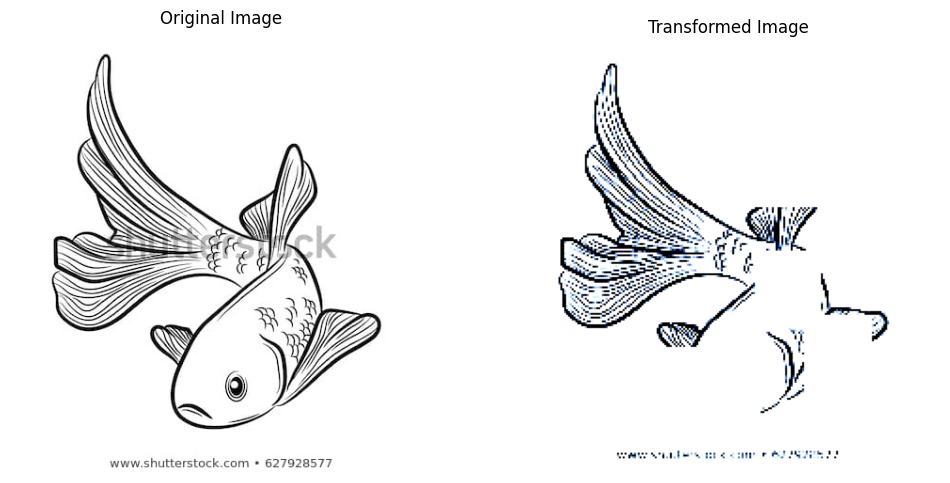

In [86]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import albumentations as A

def load_image(path):
    image = Image.open(path).convert("RGB")  # 이미지를 PIL로 불러옴
    image = np.array(image)  # NumPy 배열로 변환
    return image

def apply_transforms(image, transform):
    transformed = transform(image=image)
    return transformed['image']

def plot_images(original_img, transformed_img):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    axes[0].imshow(original_img)
    axes[0].set_title("Original Image")
    axes[0].axis("off")
    
    axes[1].imshow(transformed_img.permute(1, 2, 0).numpy())  # 텐서를 이미지로 변환
    axes[1].set_title("Transformed Image")
    axes[1].axis("off")
    
    plt.show()

# 이미지 파일 경로 설정
image_path = "/data/ephemeral/data/train/n01443537/sketch_6.JPEG"

# 이미지 불러오기
original_image = load_image(image_path)

# 랜덤 마스크 적용
coarse_dropout_transform = A.Compose([
    A.Resize(224, 224),
    A.CoarseDropout(p=1, max_holes=8, min_height=(30), max_height=(50), min_width=30, max_width=50, fill_value=255),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    A.pytorch.transforms.ToTensorV2()
])

transformed_image = apply_transforms(original_image, coarse_dropout_transform)

# 시각화
plot_images(original_image, transformed_image)


### Affine

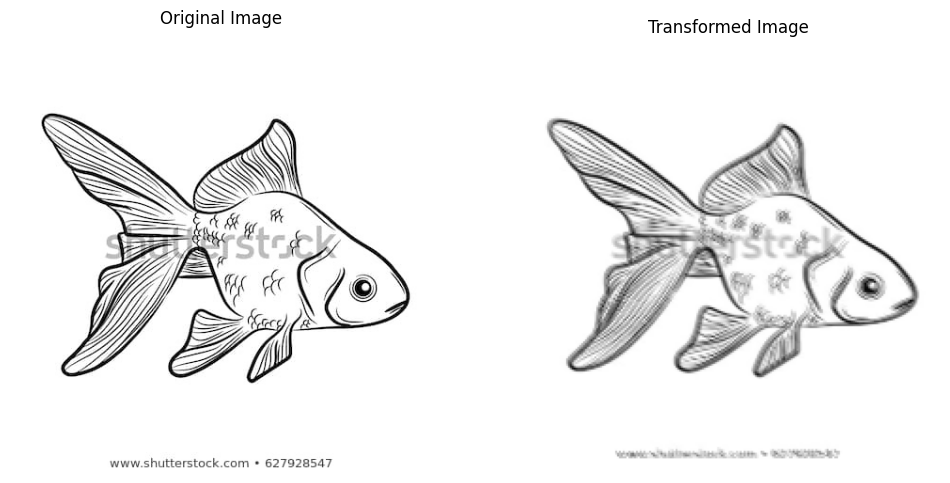

In [75]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2


def load_image(path):
    image = Image.open(path).convert("RGB")  # 이미지를 PIL로 불러옴
    image = np.array(image)  # NumPy 배열로 변환
    return image

def apply_transforms(image, transform):
    transformed = transform(image=image)
    return transformed['image']

def plot_images(original_img, transformed_img):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    axes[0].imshow(original_img)
    axes[0].set_title("Original Image")
    axes[0].axis("off")
    
    axes[1].imshow(transformed_img.permute(1, 2, 0).numpy())  # 텐서를 이미지로 변환
    axes[1].set_title("Transformed Image")
    axes[1].axis("off")
    
    plt.show()

# 이미지 파일 경로 설정
#image_path = "/data/ephemeral/data/train/n01443537/sketch_6.JPEG"

image_path = "../data/train/n01443537/sketch_15.JPEG"

# 이미지 불러오기
original_image = load_image(image_path)

# 랜덤 마스크 적용
coarse_dropout_transform = A.Compose([
    A.Resize(224, 224),
    #A.CoarseDropout(p=1, max_holes=8, min_height=(30), max_height=(50), min_width=30, max_width=50, fill_value=255),
    #A.Affine(scale=(1, 1.5), shear=(-10, 10), p=1),
    #A.ElasticTransform(alpha=500, sigma=30, p=1),
    #A.Erosion(kernel=(1, 2), p=0.5),
    #A.Dilation(kernel=(1, 2), p=0.5),
    #A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    #A.GaussNoise(var_limit=(10.0, 50.0), p=1),
    A.MotionBlur(blur_limit=(3, 7), p=1),
    ToTensorV2()
])

transformed_image = apply_transforms(original_image, coarse_dropout_transform)

# 시각화
plot_images(original_image, transformed_image)


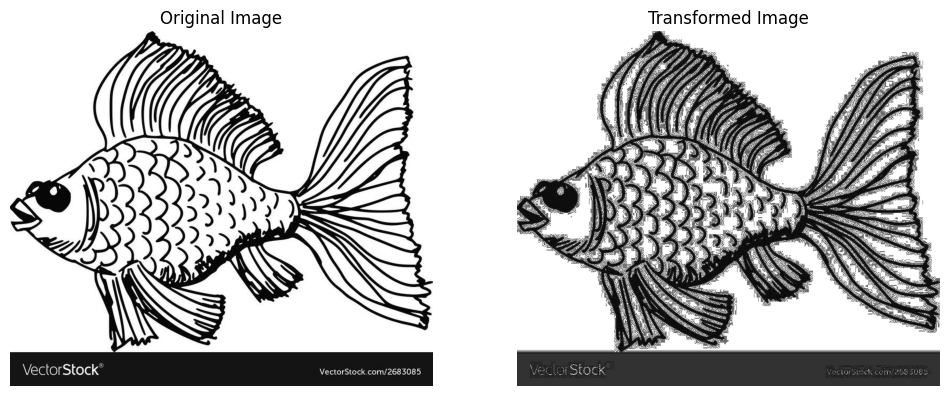

In [11]:
import cv2
import numpy as np

image_path = "../data/train/n01443537/sketch_10.JPEG"
# 이미지 로딩
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

channels = cv2.split(img)

# 히스토그램 평활화 적용
equalized_channels = [cv2.equalizeHist(channel) for channel in channels]

# 평활화된 채널을 합쳐서 최종 이미지 생성
img_eq = cv2.merge(equalized_channels)

import matplotlib.pyplot as plt

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_eq_rgb = cv2.cvtColor(img_eq, cv2.COLOR_BGR2RGB)

def plot_images(original_img, transformed_img):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    axes[0].imshow(original_img)
    axes[0].set_title("Original Image")
    axes[0].axis("off")
    
    axes[1].imshow(transformed_img)  # 텐서를 이미지로 변환
    axes[1].set_title("Transformed Image")
    axes[1].axis("off")
    
    plt.show()

plot_images(img_rgb, img_eq_rgb)

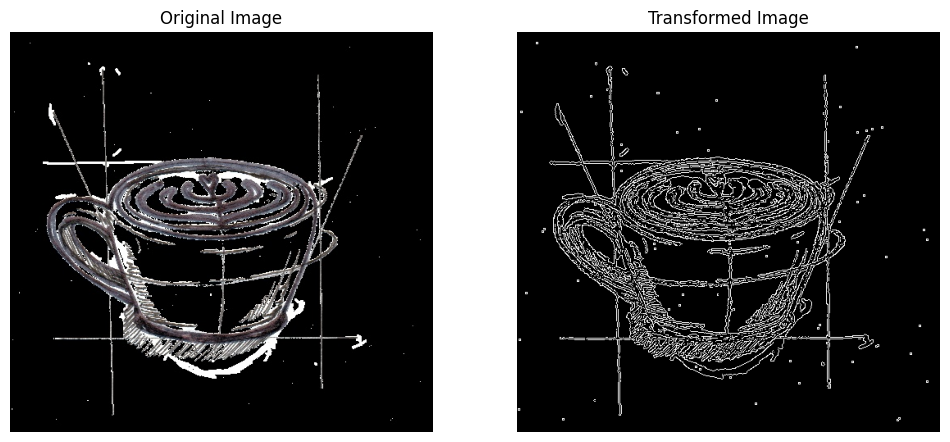

(488, 516, 3)


In [28]:
import cv2
import numpy as np

image_path = "../data/test/2144.JPEG"
# 이미지 로딩
low_threshold = 100
high_threshold = 200

img = cv2.imread(image_path, cv2.IMREAD_COLOR)
img_eq = cv2.Canny(img, low_threshold, high_threshold)
image = cv2.Canny(img, low_threshold, high_threshold)


import matplotlib.pyplot as plt

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_eq_rgb = cv2.cvtColor(img_eq, cv2.COLOR_BGR2RGB)

def plot_images(original_img, transformed_img):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    axes[0].imshow(original_img)
    axes[0].set_title("Original Image")
    axes[0].axis("off")
    
    axes[1].imshow(transformed_img)  # 텐서를 이미지로 변환
    axes[1].set_title("Transformed Image")
    axes[1].axis("off")
    
    plt.show()

plot_images(img_rgb, img_eq_rgb)

print(img_eq_rgb.shape)

In [1]:
from transformers import ConvNextImageProcessor, ConvNextForImageClassification
import torch
from datasets import load_dataset

dataset = load_dataset("huggingface/cats-image", trust_remote_code=True)
image = dataset["test"]["image"][0]

processor = ConvNextImageProcessor.from_pretrained("facebook/convnext-small-224")
model = ConvNextForImageClassification.from_pretrained("facebook/convnext-small-224")

inputs = processor(image, return_tensors="pt")

with torch.no_grad():
    logits = model(**inputs).logits

# model predicts one of the 1000 ImageNet classes
predicted_label = logits.argmax(-1).item()
print(model.config.id2label[predicted_label]),

c:\Users\kb721\miniconda3\envs\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


tabby, tabby cat


(None,)

In [2]:
model

ConvNextForImageClassification(
  (convnext): ConvNextModel(
    (embeddings): ConvNextEmbeddings(
      (patch_embeddings): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (layernorm): ConvNextLayerNorm()
    )
    (encoder): ConvNextEncoder(
      (stages): ModuleList(
        (0): ConvNextStage(
          (downsampling_layer): Identity()
          (layers): Sequential(
            (0): ConvNextLayer(
              (dwconv): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
              (layernorm): ConvNextLayerNorm()
              (pwconv1): Linear(in_features=96, out_features=384, bias=True)
              (act): GELUActivation()
              (pwconv2): Linear(in_features=384, out_features=96, bias=True)
              (drop_path): Identity()
            )
            (1): ConvNextLayer(
              (dwconv): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
              (layernorm): ConvNextLayerNorm()
              

In [3]:
import torch.nn as nn
model.classifier = nn.Identity()

In [4]:
model

ConvNextForImageClassification(
  (convnext): ConvNextModel(
    (embeddings): ConvNextEmbeddings(
      (patch_embeddings): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (layernorm): ConvNextLayerNorm()
    )
    (encoder): ConvNextEncoder(
      (stages): ModuleList(
        (0): ConvNextStage(
          (downsampling_layer): Identity()
          (layers): Sequential(
            (0): ConvNextLayer(
              (dwconv): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
              (layernorm): ConvNextLayerNorm()
              (pwconv1): Linear(in_features=96, out_features=384, bias=True)
              (act): GELUActivation()
              (pwconv2): Linear(in_features=384, out_features=96, bias=True)
              (drop_path): Identity()
            )
            (1): ConvNextLayer(
              (dwconv): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
              (layernorm): ConvNextLayerNorm()
              

In [5]:
model(**inputs)

ImageClassifierOutputWithNoAttention(loss=None, logits=tensor([[-6.2490e-02, -1.6128e-02, -2.7596e-01, -1.9633e-01, -1.3017e-01,
         -1.9565e-01, -3.4765e-02, -5.8618e-01,  2.9344e-01, -1.3805e-01,
          3.4654e-01,  1.2256e-01, -4.9288e-01, -1.9256e-01, -1.3438e-01,
         -6.9147e-02, -9.7353e-02, -3.1152e-01,  6.7916e-02, -4.3828e-01,
         -1.1187e-01, -2.2030e-01, -4.0683e-02,  3.2484e-01,  2.0613e-01,
         -9.4397e-02, -1.2940e-01,  2.6386e-01,  2.2198e-01, -5.2048e-01,
          4.2866e-01, -7.7789e-02, -4.6632e-02,  2.2601e-01,  1.5203e-01,
         -6.7079e-05, -2.3764e-01,  7.2897e-02,  2.4762e-01, -5.3848e-01,
          5.2972e-02,  3.2645e-02, -4.2022e-02,  1.4851e-01,  3.1114e-01,
         -4.8678e-01, -1.6278e-01, -3.2688e-01, -1.8218e-01, -8.6088e-03,
         -6.8548e-03,  3.8444e-01, -3.2071e-02,  2.7530e-01, -2.6113e-01,
         -2.5350e-02, -4.7156e-01,  6.1247e-01,  1.2205e-01, -2.4767e-01,
          1.7008e-01, -1.7962e-01, -1.1328e-01, -2.3598e-

In [6]:
from urllib.request import urlopen
from PIL import Image
import timm

img = Image.open(urlopen(
    'https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/beignets-task-guide.png'
))

model = timm.create_model(
    'eva02_base_patch14_224.mim_in22k',
    pretrained=True,
    num_classes=0,  # remove classifier nn.Linear
)
model = model.eval()

# get model specific transforms (normalization, resize)
data_config = timm.data.resolve_model_data_config(model)
transforms = timm.data.create_transform(**data_config, is_training=False)

output = model(transforms(img).unsqueeze(0))  # output is (batch_size, num_features) shaped tensor

# or equivalently (without needing to set num_classes=0)

output = model.forward_features(transforms(img).unsqueeze(0))
# output is unpooled, a (1, 257, 768) shaped tensor

output = model.forward_head(output, pre_logits=True)
# output is a (1, num_features) shaped tensor


In [7]:
model

Eva(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (rope): RotaryEmbeddingCat()
  (blocks): ModuleList(
    (0-11): 12 x EvaBlock(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): EvaAttention(
        (q_proj): Linear(in_features=768, out_features=768, bias=True)
        (k_proj): Linear(in_features=768, out_features=768, bias=False)
        (v_proj): Linear(in_features=768, out_features=768, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): SwiGLU(
        (fc1_g): Linear(in_features=768, out_features=2048, bias=True)
        (fc1_x): Linear(in_features=76

In [11]:
model.fc

AttributeError: 'Eva' object has no attribute 'fc'

In [17]:
swin = timm.create_model('swinv2_cr_small_224.sw_in1k', pretrained=True, num_classes=0)

In [18]:
swin

SwinTransformerV2Cr(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  )
  (stages): Sequential(
    (0): SwinTransformerV2CrStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): SwinTransformerV2CrBlock(
          (attn): WindowMultiHeadAttention(
            (qkv): Linear(in_features=96, out_features=288, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=96, out_features=96, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (meta_mlp): Mlp(
              (fc1): Linear(in_features=2, out_features=384, bias=True)
              (act): ReLU()
              (drop1): Dropout(p=0.125, inplace=False)
              (norm): Identity()
              (fc2): Linear(in_features=384, out_features=3, bias=True)
              (drop2): Dropout(p=0.0, inplace=False)
            )
          )

In [16]:
torch.cat([torch.tensor([1, 2]), torch.tensor([1, 2]), torch.tensor([1, 2])], dim=1)

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [2]:
from urllib.request import urlopen
from PIL import Image
import timm

img = Image.open(urlopen(
    'https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/beignets-task-guide.png'
))

model = timm.create_model(
    'convnextv2_base.fcmae_ft_in22k_in1k',
    pretrained=True,
    num_classes=0,  # remove classifier nn.Linear
)
model = model.eval()

# get model specific transforms (normalization, resize)
data_config = timm.data.resolve_model_data_config(model)
transforms = timm.data.create_transform(**data_config, is_training=False)

output = model(transforms(img).unsqueeze(0))  # output is (batch_size, num_features) shaped tensor

# or equivalently (without needing to set num_classes=0)

output = model.forward_features(transforms(img).unsqueeze(0))
# output is unpooled, a (1, 1024, 7, 7) shaped tensor

output = model.forward_head(output, pre_logits=True)
# output is a (1, num_features) shaped tensor


In [4]:
output.shape

torch.Size([1, 1024])

In [5]:
from urllib.request import urlopen
from PIL import Image
import timm

img = Image.open(urlopen(
    'https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/beignets-task-guide.png'
))

model = timm.create_model(
    'eva02_base_patch14_224.mim_in22k',
    pretrained=True,
    num_classes=0,  # remove classifier nn.Linear
)
model = model.eval()

# get model specific transforms (normalization, resize)
data_config = timm.data.resolve_model_data_config(model)
transforms = timm.data.create_transform(**data_config, is_training=False)

output = model(transforms(img).unsqueeze(0))  # output is (batch_size, num_features) shaped tensor

# or equivalently (without needing to set num_classes=0)

output = model.forward_features(transforms(img).unsqueeze(0))
# output is unpooled, a (1, 257, 768) shaped tensor

output = model.forward_head(output, pre_logits=True)
# output is a (1, num_features) shaped tensor


In [6]:
output.shape

torch.Size([1, 768])

In [1]:
from transformers import AutoImageProcessor, ConvNextV2ForImageClassification
import torch
from datasets import load_dataset

dataset = load_dataset("huggingface/cats-image")
image = dataset["test"]["image"][0]

preprocessor = AutoImageProcessor.from_pretrained("facebook/convnextv2-large-22k-224")
model = ConvNextV2ForImageClassification.from_pretrained("facebook/convnextv2-large-22k-224")

inputs = preprocessor(image, return_tensors="pt")

with torch.no_grad():
    logits = model(**inputs).logits

# model predicts one of the 1000 ImageNet classes
predicted_label = logits.argmax(-1).item()
print(model.config.id2label[predicted_label]),


c:\Users\kb721\miniconda3\envs\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


tabby, tabby cat


(None,)

In [2]:
output = model(**inputs)

In [3]:
output

ImageClassifierOutputWithNoAttention(loss=None, logits=tensor([[-5.0427e-02,  5.6356e-01, -1.7291e-01, -6.5074e-01, -3.9492e-01,
         -5.4289e-01, -8.0484e-01,  1.0776e+00,  1.2575e-01, -5.5560e-01,
         -1.3093e-01, -3.6160e-01, -3.1842e-01, -7.1445e-01, -2.7199e-01,
          8.7657e-03, -5.9385e-01, -6.1752e-01,  2.3905e-03, -4.0410e-01,
         -2.1930e-01, -5.3481e-01, -4.0049e-01,  2.7234e-01, -3.0376e-01,
          6.5508e-02,  3.4013e-01, -7.0078e-01, -1.0719e-03, -1.2188e+00,
          4.5432e-02, -8.4173e-01, -2.3608e-01, -5.4888e-01,  1.3336e-01,
         -8.6774e-01, -2.1942e-01,  1.7600e-01, -2.4222e-01,  8.2061e-02,
         -8.7660e-01,  7.6750e-01, -1.0656e+00, -4.1240e-01, -4.8752e-01,
         -7.7693e-02, -4.4894e-01, -9.7516e-03, -4.3786e-01, -6.6923e-01,
         -1.3753e+00,  1.6692e-01,  1.2610e-01, -1.1487e+00,  2.6814e-01,
         -1.1120e+00, -4.9351e-01,  6.9309e-01, -1.0364e+00, -9.3026e-01,
         -6.6471e-01,  2.8420e-01, -7.5453e-01, -8.8478e-

In [1]:
import timm

eva02 = timm.create_model('eva02_large_patch14_clip_224.merged2b', pretrained=True, num_classes=0)

c:\Users\kb721\miniconda3\envs\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\kb721\miniconda3\envs\myenv\Lib\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\kb721\.cache\huggingface\hub\models--timm--eva02_large_patch14_clip_224.merged2b_s4b_b131k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an adminis

In [2]:
eva02

Eva(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (rope): RotaryEmbeddingCat()
  (blocks): ModuleList(
    (0-23): 24 x EvaBlock(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (attn): EvaAttention(
        (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (k_proj): Linear(in_features=1024, out_features=1024, bias=False)
        (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (norm): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path1): Identity()
      (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (mlp): SwiGLU(
        (fc1_g): Linear(in_features=1024, out_features

In [1]:
from urllib.request import urlopen
from PIL import Image
import timm
import torch

img = Image.open(urlopen(
    'https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/beignets-task-guide.png'
))

model = timm.create_model('tf_efficientnetv2_xl.in21k_ft_in1k', pretrained=True)
model = model.eval()

# get model specific transforms (normalization, resize)
data_config = timm.data.resolve_model_data_config(model)
transforms = timm.data.create_transform(**data_config, is_training=False)

output = model(transforms(img).unsqueeze(0))  # unsqueeze single image into batch of 1

top5_probabilities, top5_class_indices = torch.topk(output.softmax(dim=1) * 100, k=5)


c:\Users\kb721\miniconda3\envs\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model

EfficientNet(
  (conv_stem): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): ConvBnAct(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNormAct2d(
          32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (drop_path): Identity()
      )
      (1): ConvBnAct(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNormAct2d(
          32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (drop_path):

In [3]:
model.classifier

Linear(in_features=1280, out_features=1000, bias=True)

In [6]:
model = timm.create_model('tf_efficientnetv2_xl.in21k_ft_in1k', pretrained=True, num_classes=500)

In [7]:
model.classifier

Linear(in_features=1280, out_features=500, bias=True)

In [1]:
from transformers import AutoFeatureExtractor, SwinForImageClassification
from PIL import Image
import requests
import torch

model = SwinForImageClassification.from_pretrained("microsoft/swin-large-patch4-window12-384-in22k")

c:\Users\kb721\miniconda3\envs\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\kb721\miniconda3\envs\myenv\Lib\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\kb721\.cache\huggingface\hub\models--microsoft--swin-large-patch4-window12-384-in22k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator

In [2]:
model

SwinForImageClassification(
  (swin): SwinModel(
    (embeddings): SwinEmbeddings(
      (patch_embeddings): SwinPatchEmbeddings(
        (projection): Conv2d(3, 192, kernel_size=(4, 4), stride=(4, 4))
      )
      (norm): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): SwinEncoder(
      (layers): ModuleList(
        (0): SwinStage(
          (blocks): ModuleList(
            (0-1): 2 x SwinLayer(
              (layernorm_before): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
              (attention): SwinAttention(
                (self): SwinSelfAttention(
                  (query): Linear(in_features=192, out_features=192, bias=True)
                  (key): Linear(in_features=192, out_features=192, bias=True)
                  (value): Linear(in_features=192, out_features=192, bias=True)
                  (dropout): Dropout(p=0.0, inplace=False)
                )
                (output): SwinSelfO